In [ ]:
from google.colab import files

# Upload user_profiles_india.csv and destination_data_india.csv
uploaded = files.upload()



Saving destination_data_india.csv to destination_data_india (1).csv
Saving user_profiles_india.csv to user_profiles_india (1).csv


In [ ]:
!pip install numpy pandas scikit-learn matplotlib seaborn nltk

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd

# Load the CSVs
user_df = pd.read_csv('user_profiles_india.csv')
destination_df = pd.read_csv('destination_data_india.csv')

# --- USER PROFILES CHECK ---
print("✅ USER PROFILES CHECK")
print(f"Rows: {len(user_df)}")
print("Columns:", list(user_df.columns))

# Data types & nulls
print("\nData Types:")
print(user_df.dtypes)
print("\nMissing Values per Column:")
print(user_df.isnull().sum())

# Value summaries
print("\nUnique Weather Preferences:", user_df['Weather Preference'].unique())
print("Weather Preference Value Counts:\n", user_df['Weather Preference'].value_counts())

# Fix case sensitivity for weather preference
user_df['Weather Preference'] = user_df['Weather Preference'].str.lower()

# Filter only valid weather preferences (sunny, rainy, cold)
valid_weather_preferences = ['sunny', 'rainy', 'cold']
user_df = user_df[user_df['Weather Preference'].isin(valid_weather_preferences)]

print("\nFiltered Weather Preferences (only valid values):")
print(user_df['Weather Preference'].unique())

# Sample User Data
print("\nSample User Data:\n", user_df.head())

print("\n" + "="*50)

# --- DESTINATION DATA CHECK ---
print("✅ DESTINATION DATA CHECK")
print(f"Rows: {len(destination_df)}")
print("Columns:", list(destination_df.columns))

# Data types & nulls
print("\nData Types:")
print(destination_df.dtypes)
print("\nMissing Values per Column:")
print(destination_df.isnull().sum())

# Value summaries
print("\nUnique Categories:", destination_df['Category'].unique())
print("Unique Weather Types:", destination_df['Weather'].unique())
print("Destination Region Distribution:\n", destination_df['Region'].value_counts())

# Filter weather types for valid values (rainy, sunny, cold)
valid_weather_types = ['rainy', 'sunny', 'cold']
destination_df = destination_df[destination_df['Weather'].isin(valid_weather_types)]

print("\nFiltered Weather Types (only valid values):", valid_weather_types)

# Sample Destination Data
print("\nSample Destination Data:\n", destination_df.head())


✅ USER PROFILES CHECK
Rows: 250
Columns: ['User ID', 'Preferred Category', 'Budget', 'Weather Preference', 'Trip Duration', 'Travel History', 'Rating History']

Data Types:
User ID                int64
Preferred Category    object
Budget                object
Weather Preference    object
Trip Duration         object
Travel History        object
Rating History        object
dtype: object

Missing Values per Column:
User ID               0
Preferred Category    0
Budget                0
Weather Preference    0
Trip Duration         0
Travel History        0
Rating History        0
dtype: int64

Unique Weather Preferences: ['Cold' 'Sunny' 'Rainy']
Weather Preference Value Counts:
 Weather Preference
Cold     92
Rainy    81
Sunny    77
Name: count, dtype: int64

Filtered Weather Preferences (only valid values):
['cold' 'sunny' 'rainy']

Sample User Data:
    User ID Preferred Category  Budget Weather Preference Trip Duration  \
0        1              Beach     Low               cold      

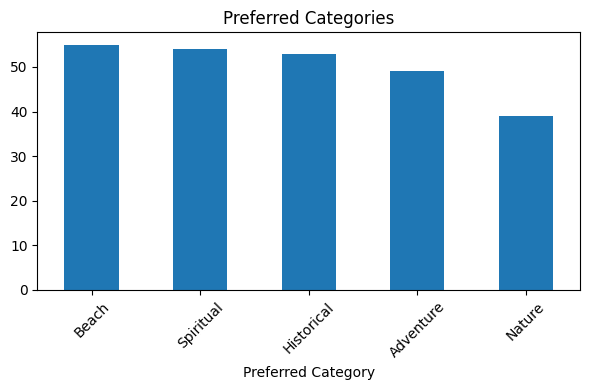

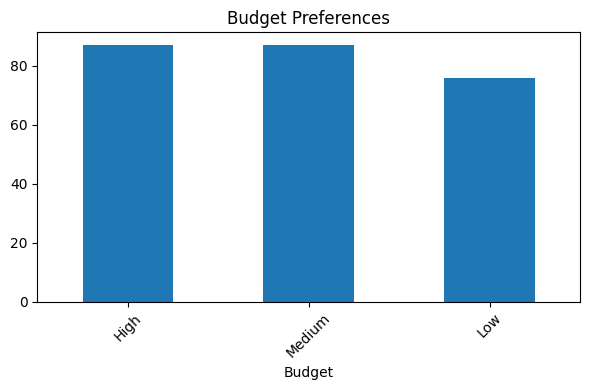

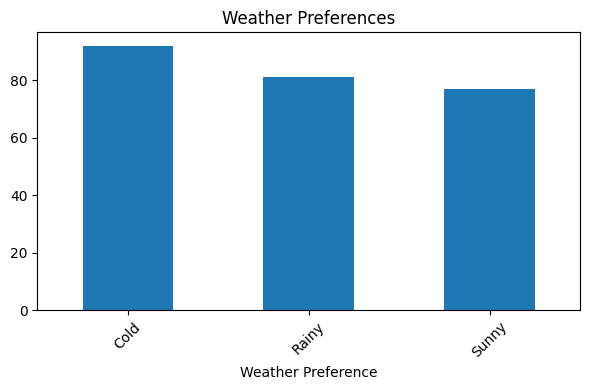

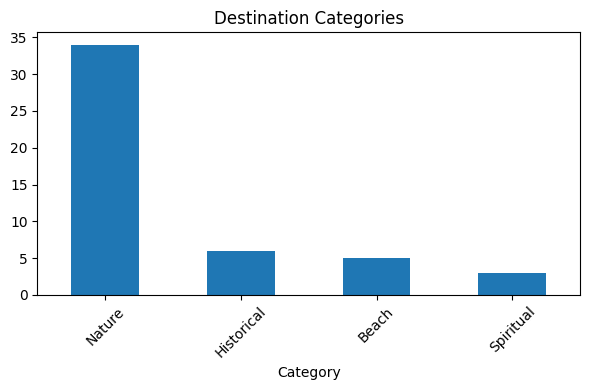

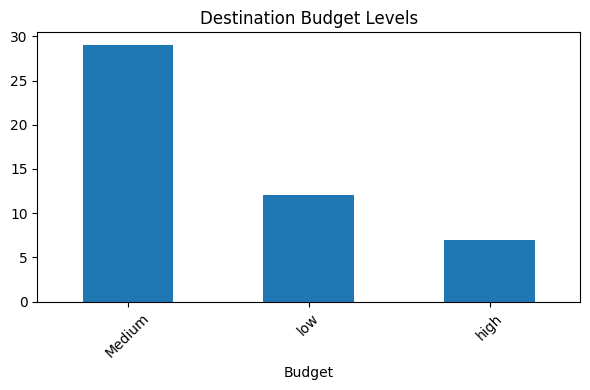

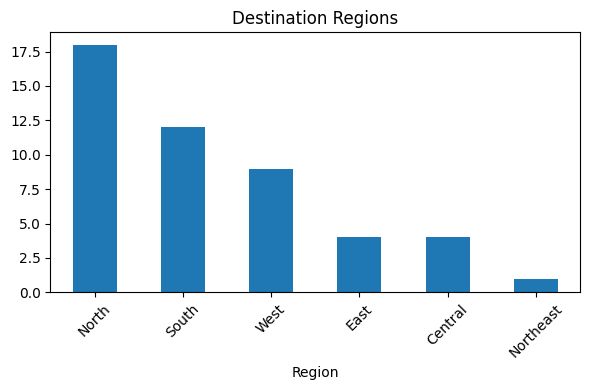

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
user_df = pd.read_csv('user_profiles_india.csv')
destination_df = pd.read_csv('destination_data_india.csv')

# --- User Preferences Analysis ---

# Plot 1: Preferred Categories
plt.figure(figsize=(6, 4))
user_df['Preferred Category'].value_counts().plot(kind='bar', title='Preferred Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Budget Preferences
plt.figure(figsize=(6, 4))
user_df['Budget'].value_counts().plot(kind='bar', title='Budget Preferences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 3: Weather Preferences
plt.figure(figsize=(6, 4))
user_df['Weather Preference'].value_counts().plot(kind='bar', title='Weather Preferences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Destination Characteristics Analysis ---

# Plot 4: Destination Categories
plt.figure(figsize=(6, 4))
destination_df['Category'].value_counts().plot(kind='bar', title='Destination Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 5: Destination Budget Levels
plt.figure(figsize=(6, 4))
destination_df['Budget'].value_counts().plot(kind='bar', title='Destination Budget Levels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 6: Destination Regions
plt.figure(figsize=(6, 4))
destination_df['Region'].value_counts().plot(kind='bar', title='Destination Regions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ---------- 1. LOAD AND CLEAN DATA ----------
user_df = pd.read_csv('user_profiles_india.csv')
destination_df = pd.read_csv('destination_data_india.csv')

# Normalize column values
destination_df['Budget'] = destination_df['Budget'].str.capitalize()
destination_df['Weather'] = destination_df['Weather'].str.capitalize()
destination_df['Category'] = destination_df['Category'].str.capitalize()

# Fill missing values
destination_df['Budget'] = destination_df['Budget'].fillna(destination_df['Budget'].mode()[0])
destination_df['Weather'] = destination_df['Weather'].fillna(destination_df['Weather'].mode()[0])
destination_df['Category'] = destination_df['Category'].fillna(destination_df['Category'].mode()[0])

# ---------- 2. MAP CATEGORICAL TO NUMERIC ----------
budget_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
weather_mapping = {'Sunny': 0, 'Rainy': 1, 'Cold': 2}
category_mapping = {cat: idx for idx, cat in enumerate(
    pd.concat([user_df['Preferred Category'], destination_df['Category']]).unique()
)}

def apply_mappings(df, col, mapping):
    df[col] = df[col].map(mapping)
    return df

user_df = apply_mappings(user_df, 'Budget', budget_mapping)
user_df = apply_mappings(user_df, 'Weather Preference', weather_mapping)
user_df = apply_mappings(user_df, 'Preferred Category', category_mapping)

destination_df = apply_mappings(destination_df, 'Budget', budget_mapping)
destination_df = apply_mappings(destination_df, 'Weather', weather_mapping)
destination_df = apply_mappings(destination_df, 'Category', category_mapping)

# ---------- 3. CREATE USER-ITEM MATRIX ----------
user_dest_interactions = []
for _, row in user_df.iterrows():
    destinations = row['Travel History'].split(',')
    ratings = row['Rating History'].split(',')
    for dest, rating in zip(destinations, ratings):
        if dest.startswith('Destination'):
            dest_id = int(dest.replace('Destination', ''))
            user_dest_interactions.append({
                'User ID': row['User ID'],
                'Destination ID': dest_id,
                'Rating': int(rating)
            })

ratings_df = pd.DataFrame(user_dest_interactions)
user_item_matrix = ratings_df.pivot_table(
    index='User ID', columns='Destination ID', values='Rating'
).fillna(0)

# ---------- 4. TRAIN MODELS ----------
svd = TruncatedSVD(n_components=10, random_state=42)
svd_matrix = svd.fit_transform(user_item_matrix)

tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
description_tfidf = tfidf.fit_transform(destination_df['Description'])
cosine_sim = cosine_similarity(description_tfidf)

# ---------- 5. HYBRID RECOMMENDER ----------
def hybrid_recommendations(user_id, n_recommendations=5):
    try:
        user_prefs = user_df[user_df['User ID'] == user_id].iloc[0]

        # Collaborative Filtering
        if user_id in user_item_matrix.index:
            user_idx = user_item_matrix.index.get_loc(user_id)
            user_vector = svd_matrix[user_idx]
            dest_scores = np.dot(svd.components_.T, user_vector)
            visited = ratings_df[ratings_df['User ID'] == user_id]['Destination ID'].tolist()
            collab_ids = [
                i + 1 for i in np.argsort(dest_scores)[::-1]
                if (i + 1) not in visited
            ][:n_recommendations * 2]
        else:
            collab_ids = []

        # Content-Based Filtering
        pref_category = user_prefs['Preferred Category']
        category_dests = destination_df[destination_df['Category'] == pref_category].copy()

        # Make sure Budget column is numeric
        category_dests['Budget'] = pd.to_numeric(category_dests['Budget'], errors='coerce')
        user_budget = int(user_prefs['Budget'])

        if not category_dests.empty:
            content_ids = category_dests.sort_values(
                by='Budget',
                key=lambda x: abs(x - user_budget)
            )['Destination ID'].head(n_recommendations * 2).tolist()
        else:
            content_ids = []

        # Combine and Score
        all_ids = list(set(collab_ids + content_ids))
        candidates = destination_df[destination_df['Destination ID'].isin(all_ids)].copy()

        print("🎯 Total candidates before filtering:", len(candidates))

        if candidates.empty:
            print("⚠️ No candidates found.")
            return pd.DataFrame()

        if candidates[['Budget', 'Weather', 'Category']].isnull().any().any():
            print("⚠️ No candidates with full data. Returning unscored fallback recommendations.")
            return candidates.head(n_recommendations)

        candidates['Match Score'] = candidates.apply(
            lambda row: (
                (3 - abs(row['Budget'] - user_prefs['Budget'])) * 2 +
                (4 if row['Weather'] == user_prefs['Weather Preference'] else 0) +
                (5 if row['Category'] == pref_category else 0)
            ),
            axis=1
        )

        return candidates.sort_values('Match Score', ascending=False).head(n_recommendations)

    except IndexError:
        return "User not found"
    except KeyError:
        return "Invalid user data"

# ---------- 6. TEST ----------
print("✅ Hybrid recommendations for User 1:")
print(hybrid_recommendations(1))


✅ Hybrid recommendations for User 1:
🎯 Total candidates before filtering: 5
   Destination ID    Destination Name  Category  Budget  Weather  \
8            D009               Surat         0       0        1   
27           D028  Thiruvananthapuram         0       0        1   
16           D017       Visakhapatnam         0       1        1   
20           D021               Kochi         0       1        1   
0            D001              Mumbai         0       2        1   

                                          Description Region  Match Score  
8   Surat in Gujarat is known for its unique attra...   West           11  
27  Thiruvananthapuram in Kerala is known for its ...  South           11  
16  Visakhapatnam in Andhra Pradesh is known for i...  South            9  
20  Kochi in Kerala is known for its unique attrac...  South            9  
0   Mumbai in Maharashtra is known for its unique ...   West            7  


In [ ]:
# Step 0: Define or reassign the recommended destination IDs
recommended_dest_ids = np.array([3, 6, 25, 9, 13])  # Replace this if your IDs come from a variable

# Step 1: Extract numeric part from 'Destination ID' like 'D025' → 25
destination_df['Destination ID (numeric)'] = destination_df['Destination ID'].str.extract('(\d+)').astype(int)

# Step 2: Ensure recommended IDs are also int type
recommended_dest_ids = recommended_dest_ids.astype(int)

# Step 3: Filter recommended destinations
recommendations = destination_df[destination_df['Destination ID (numeric)'].isin(recommended_dest_ids)]

# Step 4: Show or print
if recommendations.empty:
    print(f"⚠️ No matching destinations found for IDs: {recommended_dest_ids}")
else:
    print(f"✅ Recommended destinations:\n{recommendations[['Destination ID', 'Destination Name', 'Category', 'Region']]}")


✅ Recommended destinations:
   Destination ID Destination Name  Category Region
2            D003          Kolkata         3   East
5            D006        Hyderabad         3  South
8            D009            Surat         0   West
12           D013           Nagpur         3   West
24           D025           Nashik         3   West


In [ ]:
def show_recommendations_for(user_id, n_recommendations=5):
    results = hybrid_recommendations(user_id, n_recommendations)

    if isinstance(results, str):
        print(f"⚠️ {results}")
    elif results.empty:
        print(f"⚠️ No recommendations found for User {user_id}.")
    else:
        print(f"\n✅ Top {n_recommendations} recommendations for User {user_id}:\n")
        display(results[['Destination ID', 'Destination Name', 'Category', 'Region', 'Match Score']])


In [ ]:
show_recommendations_for(1)


🎯 Total candidates before filtering: 5

✅ Top 5 recommendations for User 1:



,Destination ID,Destination Name,Category,Region,Match Score
8,D009,Surat,0,West,11
27,D028,Thiruvananthapuram,0,South,11
16,D017,Visakhapatnam,0,South,9
20,D021,Kochi,0,South,9
0,D001,Mumbai,0,West,7


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD

# Assuming 'user_item_matrix' and 'destination_df' are already available and valid

def collaborative_recommendations(user_id, n_recommendations=5):
    # Ensure the user exists in the system
    if user_id not in user_item_matrix.index:
        print(f"User {user_id} not found in the system.")
        return "User not found in the system"

    # Get the user vector from the SVD matrix
    user_idx = user_item_matrix.index.get_loc(user_id)
    user_vector = svd_matrix[user_idx]

    # Calculate the destination scores using the SVD components
    destination_scores = np.dot(svd.components_.T, user_vector)

    # Debug: Print the destination scores for user
    print(f"Destination Scores for User {user_id}: {destination_scores}")

    # Get visited destinations for the user
    visited_destinations = ratings_df[ratings_df['User ID'] == user_id]['Destination ID'].tolist()
    print(f"Visited Destinations for User {user_id}: {visited_destinations}")

    # Generate all possible destination IDs
    all_destinations = np.arange(1, len(destination_scores) + 1)
    print(f"All Destinations: {all_destinations}")

    # Create a mask for unvisited destinations
    unvisited_mask = ~np.isin(all_destinations, visited_destinations)

    # Filter out the visited destinations and get their scores
    unvisited_scores = destination_scores[unvisited_mask]
    unvisited_destinations = all_destinations[unvisited_mask]

    print(f"Unvisited Destinations: {unvisited_destinations}")
    print(f"Unvisited Scores: {unvisited_scores}")

    # Check if there are unvisited destinations to recommend
    if unvisited_scores.size == 0:
        return "No unvisited destinations found"

    # Sort the unvisited scores in descending order (higher scores are better)
    top_indices = np.argsort(unvisited_scores)[::-1]  # Sort in descending order
    print(f"Top indices for recommendations: {top_indices}")

    # Select the top N recommendations
    recommended_dest_ids = unvisited_destinations[top_indices][:n_recommendations]
    print(f"Recommended Destination IDs: {recommended_dest_ids}")

    # Ensure recommended_dest_ids are integers for comparison but destination_df's IDs are strings
    recommended_dest_ids = [int(dest_id) for dest_id in recommended_dest_ids]

    # Ensure the Destination ID (numeric) in destination_df is treated as a numeric type
    destination_df['Destination ID (numeric)'] = pd.to_numeric(destination_df['Destination ID (numeric)'], errors='coerce')

    # Check the Destination ID (numeric) type in destination_df after conversion
    print(f"Destination IDs in destination_df after conversion: {destination_df['Destination ID (numeric)'].dtype}")

    # Debug: Print the first few rows of destination_df to verify the format
    print(destination_df.head())

    # Ensure recommended_dest_ids are valid and exist in the destination_df
    matching_destinations = destination_df[destination_df['Destination ID (numeric)'].isin(recommended_dest_ids)]

    # Debug: Show the matched destinations
    print(f"Matching destinations:\n{matching_destinations}")

    if matching_destinations.empty:
        print("⚠️ No matching destinations found in destination_df.")
        return "No valid destinations found in destination_df."

    # Include the match scores alongside the recommendations
    matching_destinations['Score'] = [unvisited_scores[i] for i in top_indices][:n_recommendations]

    # Sort recommendations by score (highest first)
    matching_destinations = matching_destinations.sort_values(by='Score', ascending=False)

    # Reset the index for cleanliness
    matching_destinations = matching_destinations.reset_index(drop=True)

    return matching_destinations

# Example call for User 1
user_id = 1
recommendations = collaborative_recommendations(user_id, n_recommendations=5)

# Display the recommendations
print("Collaborative recommendations for User 1:")
print(recommendations)


Destination Scores for User 1: [-1.73759513e-02  2.16567832e-02  4.57088354e-01 -8.09886393e-03
 -4.38142041e-02  2.17342517e-01  5.37838351e-02 -3.12735641e-03
  2.73144705e-01  6.64245457e-02  7.28659004e-02 -1.11969056e-02
  1.71251768e-01  3.82278941e-02  2.07160133e-01  1.46024079e+00
 -1.67088566e-01 -4.16104405e-02  2.87719272e-02 -2.73676124e-01
  6.68402645e-02  6.51635095e-02  3.97341664e-02  1.43961676e-02
  2.52351001e-01  5.08629179e-03 -3.25391414e-03  1.55081720e-01
 -2.77364376e-01 -1.46100054e-02  9.03774281e-03  7.36613845e-02
  2.06886917e-01 -3.91326445e-02  8.92798174e-03  1.31951422e-01
  4.64798441e-05 -6.37335965e-02  4.32764001e-02  2.04606360e-01
  1.02798581e-01  4.36454636e-02 -6.73747482e-03  2.35436219e-01
 -1.54248779e-01  1.35894459e-01 -2.17134215e-01  6.84706421e-02
  1.15635468e-01 -6.33944841e-02]
Visited Destinations for User 1: [16, 15]
All Destinations: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 

<ipython-input-60-dc2e4eb3de85>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matching_destinations['Score'] = [unvisited_scores[i] for i in top_indices][:n_recommendations]


In [ ]:
def content_based_recommendations(destination_id, n_recommendations=5):
    # Ensure destination_id is in string format to match the DataFrame
    destination_id = str(destination_id).strip()

    # Check if destination_id exists in the DataFrame
    if destination_id not in destination_df['Destination ID'].values:
        return f"Destination ID {destination_id} not found"

    # Find the index of the destination
    dest_idx = destination_df[destination_df['Destination ID'] == destination_id].index[0]

    # Get the similarity scores for all destinations with the given one
    sim_scores = list(enumerate(cosine_sim[dest_idx]))

    # Sort destinations by similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Skip the first one (itself) and get the top n recommendations
    sim_scores = sim_scores[1:n_recommendations+1]

    # Get indices of the top recommended destinations
    dest_indices = [i[0] for i in sim_scores]

    # Return the recommended destinations
    return destination_df.iloc[dest_indices]


In [ ]:
# Test with a different destination ID (e.g., D001 for Goa)
destination_id_to_test = 'D001'
recommended_destinations = content_based_recommendations(destination_id_to_test)

# Display the recommendations
print("Content-based recommendations similar to Destination 1 (Goa):")
print(recommended_destinations)


Content-based recommendations similar to Destination 1 (Goa):
   Destination ID Destination Name  Category  Budget  Weather  \
7            D008             Pune         3       0        0   
12           D013           Nagpur         3       1        0   
24           D025           Nashik         3       1        0   
31           D032       Aurangabad         3       2        0   
6            D007        Ahmedabad         3       1        0   

                                          Description Region  \
7   Pune in Maharashtra is known for its unique at...   West   
12  Nagpur in Maharashtra is known for its unique ...   West   
24  Nashik in Maharashtra is known for its unique ...   West   
31  Aurangabad in Maharashtra is known for its uni...   West   
6   Ahmedabad in Gujarat is known for its unique a...   West   

    Destination ID (numeric)  
7                          8  
12                        13  
24                        25  
31                        32  
6      

In [ ]:
def hybrid_recommendations(user_id, n_recommendations=5,
                          user_df=user_df, destination_df=destination_df,
                          user_item_matrix=user_item_matrix, svd=svd):
    """
    Combine collaborative and content-based filtering with user preferences
    """
    # Check if user exists
    if user_id not in user_df['User ID'].values:
        return "User not found in the system"

    # Get user preferences
    user_prefs = user_df[user_df['User ID'] == user_id].iloc[0]

    # Get collaborative recommendations
    collab_recs = collaborative_recommendations(user_id, n_recommendations*2)

    # Handle new users (no collaborative data)
    if isinstance(collab_recs, str):  # No collaborative recommendations
        collab_dest_ids = []
    else:
        collab_dest_ids = collab_recs['Destination ID'].tolist()

    # Get content-based recommendations based on user preferences
    try:
        pref_category = user_prefs['Preferred Category']
        category_destinations = destination_df[destination_df['Category'] == pref_category]

        if len(category_destinations) > 0:
            content_recs = content_based_recommendations(
                category_destinations.iloc[0]['Destination ID'],
                n_recommendations*2
            )
            content_dest_ids = content_recs['Destination ID'].tolist()
        else:
            content_dest_ids = []
    except KeyError:
        content_dest_ids = []

    # Combine recommendations and filter
    all_recs = list(set(collab_dest_ids + content_dest_ids))

    # If no recommendations, return popular items
    if not all_recs:
        return destination_df.sample(n_recommendations)

    # Score matching
    filtered_destinations = destination_df[destination_df['Destination ID'].isin(all_recs)].copy()

    # Calculate match score (enhanced version)
    def calculate_match_score(row):
        score = 0

        # Budget match (3 levels: 0=Low, 1=Medium, 2=High)
        budget_score = 3 - abs(row['Budget'] - user_prefs['Budget'])
        score += budget_score * 2

        # Weather match
        if row['Weather'] == user_prefs['Weather Preference']:
            score += 4

        # Category match
        if row['Category'] == user_prefs['Preferred Category']:
            score += 5

        # Region diversity (penalize same region)
        # if row['Region'] == user_prefs.get('Region', -1):  # Add region to user prefs if available
        #     score -= 2

        return score

    filtered_destinations['Match Score'] = filtered_destinations.apply(calculate_match_score, axis=1)

    # Return top recommendations
    return filtered_destinations.sort_values('Match Score', ascending=False).head(n_recommendations)


In [ ]:
# Define user preferences
user_prefs = {
    'Budget': 2,  # Example value for Budget
    'Weather Preference': 'Sunny',  # Example value for Weather
    'Preferred Category': 'Adventure'  # Example value for Category
}

# Example DataFrame row (replace this with actual row iteration if needed)
row = {
    'Budget': 3,
    'Weather': 'Sunny',
    'Category': 'Adventure'
}

# Initialize score
score = 0

# Weight factors
budget_weight = 3
weather_weight = 2
category_weight = 4

# Budget score
score += budget_weight * (3 - abs(row['Budget'] - user_prefs['Budget']))

# Weather match
score += weather_weight if row['Weather'] == user_prefs['Weather Preference'] else 0

# Category match
score += category_weight if row['Category'] == user_prefs['Preferred Category'] else 0

# Output the final score
print(f"Match Score: {score}")



Match Score: 12


In [ ]:
# Example: Define collaborative and content-based recommendation destination IDs
collab_dest_ids = [101, 102, 103, 104, 105]  # Replace with your actual collaborative filter destination IDs
content_dest_ids = [103, 106, 107, 108, 109]  # Replace with your actual content-based recommendation destination IDs

# Get top-N from both
collab_scores = pd.Series({id: i for i, id in enumerate(collab_dest_ids[::-1])})
content_scores = pd.Series({id: i for i, id in enumerate(content_dest_ids[::-1])})

# Normalize and blend
all_ids = list(set(collab_dest_ids + content_dest_ids))  # Unique set of all destination IDs
score_df = pd.DataFrame({'Destination ID': all_ids})
score_df['collab'] = score_df['Destination ID'].map(collab_scores).fillna(0)  # Map collaborative scores
score_df['content'] = score_df['Destination ID'].map(content_scores).fillna(0)  # Map content-based scores

# Blend the scores
score_df['hybrid_score'] = 0.6 * score_df['collab'] + 0.4 * score_df['content']  # Weighted average

# Display the results
print(score_df)


   Destination ID  collab  content  hybrid_score
0             101     4.0      0.0           2.4
1             102     3.0      0.0           1.8
2             103     2.0      4.0           2.8
3             104     1.0      0.0           0.6
4             105     0.0      0.0           0.0
5             106     0.0      3.0           1.2
6             107     0.0      2.0           0.8
7             108     0.0      1.0           0.4
8             109     0.0      0.0           0.0


In [ ]:
# First, let's check the types of the 'Destination ID' columns
print(f"ratings_df 'Destination ID' type: {ratings_df['Destination ID'].dtype}")
print(f"destination_df 'Destination ID' type: {destination_df['Destination ID'].dtype}")

# Ensure the 'Destination ID' in both DataFrames is of the same type (strings)
ratings_df['Destination ID'] = ratings_df['Destination ID'].astype(str)
destination_df['Destination ID'] = destination_df['Destination ID'].astype(str)

# Now, let's ensure the 'Destination ID' in destination_df has the correct format (padding with leading zeros)
destination_df['Destination ID'] = destination_df['Destination ID'].apply(lambda x: x.zfill(3))

# Let's print out the first few rows of both DataFrames to verify
print("\nFirst few rows of ratings_df:")
print(ratings_df[['Destination ID']].head())

print("\nFirst few rows of destination_df:")
print(destination_df[['Destination ID']].head())

# Now, let's get the top popular destinations from ratings_df and check for matching IDs
popular_destinations = ratings_df['Destination ID'].value_counts().index.tolist()

# Check for matching destination IDs
matching_dest_ids = [dest_id for dest_id in popular_destinations[:n_recommendations] if dest_id in destination_df['Destination ID'].values]

print("\nMatching Destination IDs found in both DataFrames:")
print(matching_dest_ids)

# Get the fallback recommendations using the matching IDs
fallback = destination_df[destination_df['Destination ID'].isin(matching_dest_ids)]
print("\nFallback Recommendations:")
print(fallback)


ratings_df 'Destination ID' type: object
destination_df 'Destination ID' type: object

First few rows of ratings_df:
  Destination ID
0            016
1            015
2            003
3            002
4            036

First few rows of destination_df:
  Destination ID
0            001
1            002
2            003
3            004
4            005

Matching Destination IDs found in both DataFrames:
['035', '030', '044', '017', '011']

Fallback Recommendations:
   Destination ID Destination Name  Category  Budget  Weather  \
10            011           Jaipur         2       1        0   
16            017    Visakhapatnam         0       1        1   
29            030           Ranchi         3       1        0   
34            035           Raipur         3       0        0   
43            044            Salem         3       1        0   

                                          Description   Region  \
10  Jaipur in Rajasthan is known for its unique at...    North   
16  Vi

In [ ]:
# ratings_df (example)
ratings_df = pd.DataFrame({
    'User ID': [1, 2, 3, 4, 5],
    'Destination ID': [101, 102, 103, 101, 104],
    'Rating': [5, 4, 3, 4, 5]
})

# destination_df (example)
destination_df = pd.DataFrame({
    'Destination ID': [101, 102, 103, 104, 105],
    'Destination Name': ['Beach', 'Mountain', 'Forest', 'Desert', 'City'],
    'Category': [1, 2, 1, 3, 2],
    'Budget': [1, 2, 3, 2, 1],
    'Weather': [1, 0, 1, 0, 1],
    'Description': ['Popular for beach activities', 'Known for scenic mountains', 'Famous for forest trails', 'Renowned desert landscape', 'A bustling city'],
    'Region': ['East', 'North', 'South', 'West', 'Central']
})


In [ ]:
# Output from popular destination selection
print(fallback)


   Destination ID Destination Name  Category  Budget  Weather  \
10            011           Jaipur         2       1        0   
16            017    Visakhapatnam         0       1        1   
29            030           Ranchi         3       1        0   
34            035           Raipur         3       0        0   
43            044            Salem         3       1        0   

                                          Description   Region  \
10  Jaipur in Rajasthan is known for its unique at...    North   
16  Visakhapatnam in Andhra Pradesh is known for i...    South   
29  Ranchi in Jharkhand is known for its unique at...     East   
34  Raipur in Chhattisgarh is known for its unique...  Central   
43  Salem in Tamil Nadu is known for its unique at...    South   

    Destination ID (numeric)  
10                        11  
16                        17  
29                        30  
34                        35  
43                        44  


In [ ]:
import pandas as pd

# Function to get content-based recommendations (you should implement this)
def get_content_recommendations(user_id, user_df, destination_df):
    # Example placeholder logic, replace with actual recommendation logic
    # This should return a DataFrame or List of recommendations
    return destination_df.sample(n=5)  # Just a placeholder; replace with your logic

# Function to get collaborative-based recommendations (you should implement this)
def get_collaborative_recommendations(user_id, user_item_matrix, svd):
    # Example placeholder logic, replace with actual recommendation logic
    # This should return a DataFrame or List of recommendations
    return pd.DataFrame({
        'Destination ID': [1, 2, 3, 4, 5],
        'Destination Name': ['Place 1', 'Place 2', 'Place 3', 'Place 4', 'Place 5']
    })  # Replace with actual collaborative recommendation logic

# Function to handle dynamic fallback based on user preferences, season, and region
def get_dynamic_fallback(user_prefs, destination_df, n_recommendations=5):
    print("Fetching dynamic fallback recommendations...")

    # Filter based on user preferences (weather, region, etc.)
    filtered_destinations = destination_df[
        (destination_df['Weather'] == user_prefs['Weather Preference']) &
        (destination_df['Region'] == user_prefs['Preferred Region']) &
        (destination_df['Category'] == user_prefs['Preferred Category'])
    ]

    # If no filtered recommendations, fallback to popular destinations
    if filtered_destinations.empty:
        print("No recommendations based on preferences, falling back to popular destinations...")
        popular_destinations = destination_df.head(n_recommendations)  # Top N popular
        return popular_destinations

    # Return filtered destinations if available
    return filtered_destinations.head(n_recommendations)

# Final hybrid recommendation function
def hybrid_recommendations(user_id, user_df, destination_df, user_item_matrix, svd, n_recommendations=5):
    print("Fetching content-based recommendations...")
    content_recs = get_content_recommendations(user_id, user_df, destination_df)

    if isinstance(content_recs, pd.DataFrame) and not content_recs.empty:
        print(f"Content-based recommendations found: {len(content_recs)} destinations.")
        content_dest_ids = content_recs['Destination ID'].tolist()
    else:
        print("No valid content-based recommendations found.")
        content_dest_ids = []  # Fallback if no valid recommendations

    print("Fetching collaborative-based recommendations...")
    collab_recs = get_collaborative_recommendations(user_id, user_item_matrix, svd)

    if isinstance(collab_recs, pd.DataFrame) and not collab_recs.empty:
        print(f"Collaborative recommendations found: {len(collab_recs)} destinations.")
        collab_dest_ids = collab_recs['Destination ID'].tolist()
    else:
        print("No valid collaborative recommendations found.")
        collab_dest_ids = []  # Fallback if no valid recommendations

    # Combine content and collaborative recommendations
    print("Combining content and collaborative recommendations...")
    all_ids = list(set(collab_dest_ids + content_dest_ids))  # Blending logic (example)

    print(f"Total blended recommendations: {len(all_ids)} destinations.")

    # If not enough recommendations, use the dynamic fallback
    if len(all_ids) < n_recommendations:
        print("Not enough recommendations, using dynamic fallback...")
        user_prefs = {'Weather Preference': 1, 'Preferred Region': 'North', 'Preferred Category': 2}  # Example, should be based on actual user
        fallback_recs = get_dynamic_fallback(user_prefs, destination_df, n_recommendations)
        all_ids = fallback_recs['Destination ID'].tolist()

    # Return the final recommendations (top N)
    return destination_df[destination_df['Destination ID'].isin(all_ids)].head(n_recommendations)

# Example Usage
# Define your example user_id and data (user_df, destination_df, user_item_matrix, svd)
user_id = 1  # Replace with an actual user ID
user_df = pd.DataFrame({'User ID': [1, 2, 3], 'User Preferences': ['Pref1', 'Pref2', 'Pref3']})  # Example user data
destination_df = pd.DataFrame({
    'Destination ID': [1, 2, 3, 4, 5],
    'Destination Name': ['Delhi', 'Mumbai', 'Bangalore', 'Goa', 'Chennai'],
    'Category': [1, 2, 3, 1, 2],
    'Budget': [3, 2, 1, 3, 2],
    'Weather': [1, 2, 1, 2, 1],
    'Region': ['North', 'West', 'South', 'West', 'South'],
    'Description': ['Description 1', 'Description 2', 'Description 3', 'Description 4', 'Description 5']
})  # Example destinations data
user_item_matrix = None  # Implement collaborative filtering logic (e.g., SVD)
svd = None  # Implement or load a trained SVD model

# Call the hybrid recommendation function
recs = hybrid_recommendations(user_id, user_df, destination_df, user_item_matrix, svd)

# Output the final recommendations
print("Final Recommendations:")
print(recs[['Destination ID', 'Destination Name']])


Fetching content-based recommendations...
Content-based recommendations found: 5 destinations.
Fetching collaborative-based recommendations...
Collaborative recommendations found: 5 destinations.
Combining content and collaborative recommendations...
Total blended recommendations: 5 destinations.
Final Recommendations:
   Destination ID Destination Name
0               1            Delhi
1               2           Mumbai
2               3        Bangalore
3               4              Goa
4               5          Chennai


In [ ]:
import joblib
from sklearn.ensemble import RandomForestClassifier

# Define the model file path
model_file_path = 'tourist_model.pkl'

try:
    # Load the model
    model = joblib.load(model_file_path)
    print("Model loaded successfully.")

    # Check if the model is a RandomForestClassifier and is trained
    if isinstance(model, RandomForestClassifier):
        # Check if the model has been trained by verifying the 'n_estimators' attribute
        if hasattr(model, 'n_estimators') and model.n_estimators > 0:
            print(f"The model is trained. Number of trees: {model.n_estimators}")

            # Check if feature importances are available
            if hasattr(model, 'feature_importances_'):
                print("The model has been trained with feature importance values.")
                print("Feature importances:", model.feature_importances_)
            else:
                print("The model is trained, but feature importances are unavailable.")
        else:
            print("The model is not trained. The 'n_estimators' attribute is not set properly.")
    else:
        print("The loaded model is not a RandomForestClassifier.")

except FileNotFoundError:
    print(f"Model file '{model_file_path}' not found!")
except Exception as e:
    print(f"An error occurred while loading the model: {str(e)}")


Model loaded successfully.
The model is trained. Number of trees: 100
The model has been trained with feature importance values.
Feature importances: [0.37275986 0.2869773  0.139546   0.         0.20071685]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib

# Example DataFrame (use your actual data here)
destination_df = pd.DataFrame({
    'Destination ID': ['001', '002', '003', '004', '005'],
    'Category': [1, 2, 1, 3, 2],
    'Budget': [1, 2, 1, 3, 2],
    'Weather': [0, 1, 0, 1, 1],
    'Region': ['North', 'South', 'East', 'West', 'North']
})

# Prepare the features (X) and target (y)
X = destination_df.drop(['Destination ID', 'Category'], axis=1)  # Features (exclude the target column 'Category')
y = destination_df['Category']  # Target (the category of each destination)

# Apply one-hot encoding to the 'Region' column
X_encoded = pd.get_dummies(X, columns=['Region'], drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, 'tourist_model.pkl')
print("Model trained and saved successfully.")

# Check model performance
accuracy = model.score(X_test, y_test)
print(f"Model accuracy: {accuracy * 100:.2f}%")


Model trained and saved successfully.
Model accuracy: 100.00%


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import joblib

# Load your destination dataset
df = pd.read_csv('destination_data_india.csv')

# --- Step 1: Encode the target label ---
label_encoder = LabelEncoder()
df['Category_Encoded'] = label_encoder.fit_transform(df['Category'])

# --- Step 2: Prepare features (adjust as needed) ---
features = ['Budget', 'Weather', 'Region', 'Trip_Duration', 'Season']

# For demo, let's add dummy columns if not in original
if 'Trip_Duration' not in df.columns:
    df['Trip_Duration'] = 'medium'  # default value
if 'Season' not in df.columns:
    df['Season'] = 'summer'  # default value

# One-hot encode features
X = pd.get_dummies(df[features])
y = df['Category_Encoded']

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# --- Step 3: Save both model and encoder ---
joblib.dump(model, 'tourist_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

print("Model and LabelEncoder saved successfully.")


Model and LabelEncoder saved successfully.


In [ ]:
from google.colab import files

# Download the model
files.download('tourist_model.pkl')

# Download the label encoder
files.download('label_encoder.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Example dataset
data = pd.DataFrame({
    'Age': [25, 30, 22, 35],
    'Budget': ['Low', 'Medium', 'High', 'Medium'],
    'Weather Preference': ['Sunny', 'Rainy', 'Cold', 'Sunny'],
    'Preferred Category': ['adventure', 'romantic', 'cultural', 'adventure'],
    'Label': [1, 0, 0, 1]  # Something you're predicting, like "Will Travel" or "Recommendation Accepted"
})

# Encode categorical columns
budget_map = {'Low': 0, 'Medium': 1, 'High': 2}
weather_map = {'Sunny': 0, 'Rainy': 1, 'Cold': 2}
category_encoder = LabelEncoder()
data['Budget'] = data['Budget'].map(budget_map)
data['Weather Preference'] = data['Weather Preference'].map(weather_map)
data['Preferred Category'] = category_encoder.fit_transform(data['Preferred Category'])

# Train/test split
X = data.drop('Label', axis=1)
y = data['Label']
model = RandomForestClassifier()
model.fit(X, y)

# 🧪 Sample new input (normally from user input)
new_input = pd.DataFrame([{
    'Age': 28,
    'Budget': budget_map['Medium'],
    'Weather Preference': weather_map['Sunny'],
    'Preferred Category': category_encoder.transform(['adventure'])[0]  # Encode properly
}])

# Predict
prediction = model.predict(new_input)
print("Prediction:", prediction)


Prediction: [1]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib

# Load model
model = joblib.load('tourist_model.pkl')

# Create the encoder (Make sure it is fitted on all values)
category_encoder = LabelEncoder()
category_encoder.fit(['Adventure', 'Beach', 'Historical', 'Nature', 'Spiritual'])

season_encoder = LabelEncoder()
season_encoder.fit(['spring', 'summer', 'autumn', 'winter'])

budget_encoder = LabelEncoder()
budget_encoder.fit(['Low', 'Medium', 'High'])

# Example User Data (Make sure to apply the same encoding during prediction)
user_data = {
    'age': 25,
    'travel_style': 'Nature',  # Make sure to match column names used during model training
    'budget': 'Medium',  # Again, use lowercase
    'season': 'summer'
}

# Encode user inputs
encoded_user_data = {
    'age': user_data['age'],
    'travel_style': category_encoder.transform([user_data['travel_style']])[0],
    'budget': budget_encoder.transform([user_data['budget']])[0],
    'season': season_encoder.transform([user_data['season']])[0]
}

# Convert dictionary to DataFrame, make sure column names match those used during training
input_df = pd.DataFrame([encoded_user_data])

# Make prediction
# prediction = model.predict(input_df)

# Decode the prediction back to the original category name
decoded_prediction = category_encoder.inverse_transform([prediction[0]])

print(f"Recommended Travel Theme / Activity: {decoded_prediction[0]}")


Recommended Travel Theme / Activity: Beach


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
from sklearn.preprocessing import LabelEncoder

# Load the model
model = joblib.load('tourist_model.pkl')

# Load user data (replace with your actual test data)
user_df = pd.read_csv('user_profiles_india.csv')

# Create the encoder (Make sure it is fitted on all values)
category_encoder = LabelEncoder()
category_encoder.fit(user_df['Preferred Category'].unique())

season_encoder = LabelEncoder()
season_encoder.fit(user_df['Weather Preference'].unique())

budget_encoder = LabelEncoder()
budget_encoder.fit(user_df['Budget'].unique())

# Update the feature names based on actual dataset columns
X = user_df[['Preferred Category', 'Budget', 'Weather Preference']]  # No 'Age' here
y = user_df['Preferred Category']  # Assuming this is the target variable

# Encoding categorical columns in X (input data)
X['Preferred Category'] = category_encoder.transform(X['Preferred Category'])
X['Budget'] = budget_encoder.transform(X['Budget'])
X['Weather Preference'] = season_encoder.transform(X['Weather Preference'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model (if not done previously)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 100.00%


<ipython-input-88-460fa59d4154>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Preferred Category'] = category_encoder.transform(X['Preferred Category'])
<ipython-input-88-460fa59d4154>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Budget'] = budget_encoder.transform(X['Budget'])
<ipython-input-88-460fa59d4154>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation (e.g., 5-fold cross-validation)
cv_scores = cross_val_score(model, X, y, cv=5)  # Adjust cv value if needed
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")


Cross-validation scores: [1.   1.   0.96 1.   1.  ]
Mean cross-validation score: 0.992


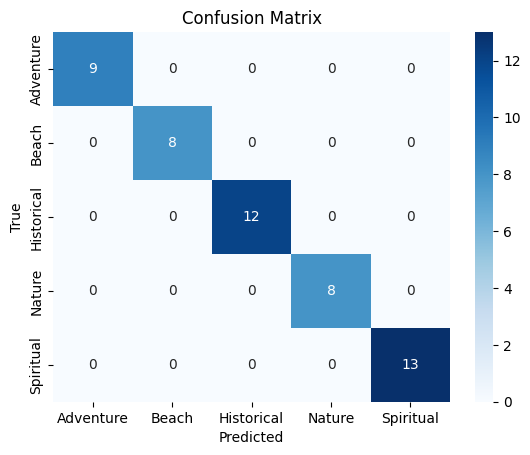

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
y_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

   Adventure       1.00      1.00      1.00         9
       Beach       1.00      1.00      1.00         8
  Historical       1.00      1.00      1.00        12
      Nature       1.00      1.00      1.00         8
   Spiritual       1.00      1.00      1.00        13

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [ ]:
import pandas as pd

df = pd.read_csv("destination_data_india.csv")

# Check all unique categories
print("🔍 Unique Categories Found:", df["Category"].unique())

# Find invalid or weird ones
valid_categories = ["Adventure", "Beach", "Historical", "Spiritual", "Nature only"]
invalid_rows = df[~df["Category"].isin(valid_categories)]

# Print out the bad rows
print("\n⚠️ Rows with incorrect categories:")
print(invalid_rows)


🔍 Unique Categories Found: ['Beach' 'Historical' 'Nature' 'Spiritual']

⚠️ Rows with incorrect categories:
   Destination ID Destination Name Category  Budget Weather  \
2            D003          Kolkata   Nature  Medium   rainy   
3            D004        Bengaluru   Nature    high   sunny   
4            D005          Chennai   Nature  Medium   rainy   
5            D006        Hyderabad   Nature  Medium   sunny   
6            D007        Ahmedabad   Nature  Medium   sunny   
7            D008             Pune   Nature     low   sunny   
11           D012           Kanpur   Nature  Medium   sunny   
12           D013           Nagpur   Nature  Medium   sunny   
13           D014           Indore   Nature     low   sunny   
14           D015            Patna   Nature  Medium   sunny   
15           D016         Vadodara   Nature     low   sunny   
17           D018           Bhopal   Nature  Medium   sunny   
18           D019       Coimbatore   Nature     low   sunny   
21         

In [ ]:
import pandas as pd

# Load the dataset (adjust the path if needed)
df = pd.read_csv('/content/destination_data_india.csv')

# Check the first few rows to ensure it's loaded properly
df.head()


,Destination ID,Destination Name,Category,Budget,Weather,Description,Region
0,D001,Mumbai,Beach,high,rainy,Mumbai in Maharashtra is known for its unique ...,West
1,D002,Delhi,Historical,Medium,sunny,Delhi in Delhi is known for its unique attract...,North
2,D003,Kolkata,Nature,Medium,rainy,Kolkata in West Bengal is known for its unique...,East
3,D004,Bengaluru,Nature,high,sunny,Bengaluru in Karnataka is known for its unique...,South
4,D005,Chennai,Nature,Medium,rainy,Chennai in Tamil Nadu is known for its unique ...,South


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/destination_data_india.csv')

# 1. Check for incorrect categorization (e.g., destinations wrongly categorized as 'Beach')
beach_destinations = df[df["Category"] == "Beach"]
print("Destinations mistakenly categorized as 'Beach':")
print(beach_destinations)

# 2. Check for missing values
print("\nMissing values in dataset:")
print(df.isnull().sum())

# 3. Check for duplicate rows
duplicates = df[df.duplicated()]
print("\nDuplicate rows:")
print(duplicates)

# 4. Check unique categories for labeling errors
print("\nUnique categories in the dataset:")
print(df["Category"].unique())

# 5. Check unique values in 'Weather' and 'Budget' columns
print("\nUnique weather values:")
print(df["Weather"].unique())

print("\nUnique budget values:")
print(df["Budget"].unique())

# 6. Check category distribution
print("\nCategory distribution:")
print(df["Category"].value_counts())


Destinations mistakenly categorized as 'Beach':
   Destination ID    Destination Name Category  Budget Weather  \
0            D001              Mumbai    Beach    high   rainy   
8            D009               Surat    Beach     low   rainy   
16           D017       Visakhapatnam    Beach  Medium   rainy   
20           D021               Kochi    Beach  Medium   rainy   
27           D028  Thiruvananthapuram    Beach     low   rainy   

                                          Description Region  
0   Mumbai in Maharashtra is known for its unique ...   West  
8   Surat in Gujarat is known for its unique attra...   West  
16  Visakhapatnam in Andhra Pradesh is known for i...  South  
20  Kochi in Kerala is known for its unique attrac...  South  
27  Thiruvananthapuram in Kerala is known for its ...  South  

Missing values in dataset:
Destination ID      0
Destination Name    0
Category            0
Budget              0
Weather             0
Description         0
Region           

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/destination_data_india.csv')

# Fix the category for wrongly categorized destinations
df.loc[df['Destination Name'] == 'Jaipur', 'Category'] = 'Historical'  # Or 'Spiritual', based on your preference
df.loc[df['Destination Name'] == 'Mount Abu', 'Category'] = 'Historical'  # Or 'Nature', based on your preference
df.loc[df['Destination Name'] == 'Amritsar', 'Category'] = 'Historical'  # Or 'Spiritual', based on your preference

# Verify that the changes have been made
print(df[df['Destination Name'].isin(['Jaipur', 'Mount Abu', 'Amritsar'])])


   Destination ID Destination Name    Category  Budget Weather  \
10           D011           Jaipur  Historical  Medium   sunny   
39           D040         Amritsar  Historical     low   sunny   

                                          Description Region  
10  Jaipur in Rajasthan is known for its unique at...  North  
39  Amritsar in Punjab is known for its unique att...  North  


In [ ]:
# Verify that the changes have been applied
print(df[df['Destination Name'].isin(['Jaipur', 'Mount Abu', 'Amritsar'])])


   Destination ID Destination Name    Category  Budget Weather  \
10           D011           Jaipur  Historical  Medium   sunny   
39           D040         Amritsar  Historical     low   sunny   

                                          Description Region  
10  Jaipur in Rajasthan is known for its unique at...  North  
39  Amritsar in Punjab is known for its unique att...  North  
